In [108]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import nltk
import emoji

from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.tree import plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import eli5



pd.set_option('display.max_colwidth', None)



plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
plt.rcParams['figure.figsize'] = (20, 10)
sns.set(style="whitegrid") # seteando tipo de grid en seaborn
pd.options.display.float_format = '{:20,.10f}'.format # suprimimos la notacion cientifica en los outputs

SMALL_SIZE = 8
MEDIUM_SIZE = 11
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


from IPython.core.pylabtools import figsize
plt.rcParams['figure.figsize'] = (9, 6)


# Funciones Generales

In [224]:
NOTICIEROS = ['cnn', 'bbc', 'reuters', 'blomberg', 'herald', 'herald', 'abc', 'fox', 'cbs', \
            'yorker', 'times', 'guardian', 'thesun', 'the sun', 'observer', 'five', 'jazeera', 'news', 'live']

PAIS_DESASTRES = ['usa', 'united states', 'canada', 'island', 'japan', 'nigeria', 'turkey', 'saudi', \
                  'malaysia']

CIUDAD_DESASTRES = ['california', 'new york', 'nyc', 'hawaii', 'hiroshima', 'fukushima', 'calgary']
 
DESASTRES_CONOCIDOS = ['mh370', 'air', 'huracan', 'fire', 'water', 'kill', 'disaster', 'suicide', 'police', 'people', \
                      'flood', 'police', 'home', 'family', 'train', 'storm', 'building', 'crash', 'hiroshima', \
                      'bomb', 'isis', 'bombing', 'wreckage', 'earthquake', 'wild', 'wildfire', 'weather', \
                      'violent', 'attack', 'tornado', 'traffic', 'thunder', 'terror', 'suspect', 'swallow',\
                      'sin', 'severe', 'security', 'refugee', 'refugio', 'release', 'report', 'rescue', 'plane',\
                      'passenger', 'offic', 'nuclear', 'north', 'natural', 'national', 'murder', 'migrant', \
                      'mass', 'land', 'issue', 'hurricane', 'injured', 'hostage', 'flood', 'evacua']
ZONAS_CONFLICTO = ['israel', 'iran', 'turkey']




CORTE_LENGHT_TEXT = 100


#Imprimir metricas de las predicciones
def mostrar_metricas(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    print(confusion_matrix (y_test, y_pred))

    # Obtener y reformar la matriz de datos de 
    matrix = confusion_matrix (y_test, y_pred) 
    matrix = matrix.astype ('float') / matrix.sum (axis = 1) [:, np.newaxis] 

    # Build the plot
    plt.figure()
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10},cmap=plt.cm.Greens, linewidths=0.2)
    plt.xlabel('Predicción')
    plt.ylabel('Target')
    plt.title('Matriz de confusión')
    plt.show()
    
def grafico_pie(df, titulo, valores, etiquetas):
    fig = px.pie(df, values=valores, names=etiquetas)
    fig.update_layout(title_text=titulo,
                      template="plotly_white")
    fig.show()
    
def grafico_distr(df, columna, titulo, xtitulo, ytitulo):
    x1 = df.loc[df['target'] == 1][columna]
    x2 = df.loc[df['target'] == 0][columna]
    group_labels = ['Verdadero', 'Falso']
    colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']
    fig = ff.create_distplot([x1, x2], group_labels,colors=colors)
    fig.update_layout(title_text=titulo,
                      xaxis_title=xtitulo,
                      yaxis_title=ytitulo,
                      template="plotly_white")
    fig.show()

# Referencia a un diario o noticiero
def news_ref(text):
    for word in NOTICIEROS:
        if word in text:
            return True
    return False



#Categoría ancho mensajes
def text_lenght_category(text):
    if len(text) > CORTE_LENGHT_TEXT:
        return True
    else:
        return False
def desastre_conocido(text):
    for dis in DESASTRES_CONOCIDOS:
        if dis in text:
            return True
    return False

#Pais de desastre
def es_pais_de_desastres(text):
    for word in text.split():
        if word in PAIS_DESASTRES:
            return True
    return False

#Ciudad de desastre
def es_ciudad_de_desastres(text):
    for word in text.split():
        if word in CIUDAD_DESASTRES:
            return True
    return False

def resultados(pred, test_df):
    res_df=pd.DataFrame(test_df['id'])
    res_df['target']=pred
    res_df.to_csv('data/submission.csv', index=False)
    
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.corpus import brown
from nltk.tag import pos_tag
from textblob import TextBlob

import re, string
from string import punctuation


stops = set(stopwords.words('english'))
#punctuation = list(string.punctuation)
punctuation = '!"$%&\()*+,-/:;<=>?[\\]“”^_`#{|}~’'


word_list = brown.words()
word_set = set(word_list)

def eliminar_char_espec(text):
    text = re.sub('[^\'A-Za-z0-9]+', ' ', text)
    return text
def idioma(text):
    tb = TextBlob(text)
    return tb.detect_language()

def sentimiento(text):
    tb = TextBlob(text)
    return tb.sentiment[0]

def unir_texto(text):
    return ( ' '.join(text))

def eliminar_palabras_con(text, con):
    palabras = []
    for word in text.split():
        if con not in word:
            palabras.append(word)
    return unir_texto(palabras)


# Tipo de palabra
#https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

#Lematizar palabras
englishStemmer=SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

#Elimino stops words 
def eliminar_sw(text):
    final_text = []
    for i in text.split():
        if i.strip() not in stops: 
            pos = pos_tag([i.strip()])
            #word = lemmatizer.lemmatize(i.strip(),get_simple_pos(pos[0][1]))
            final_text.append(i.strip())
    return unir_texto(final_text)
def cant_stopwords(text):
    cant = 0
    for i in text.split():
        if i.strip() in stops: 
            cant = cant + 1
    return cant
def minusculas(text):
    return text.lower()

def eliminar_nums(text):
    cadena = []
    for x in text:
         if x not in string.digits:
                cadena.append(x)
    return  ''.join(cadena)

def eliminar_punct(text):
    cadena = []
    for x in text:
         if x not in punctuation:
                cadena.append(x)
    return  ''.join(cadena)
        
#Generar CSV para el envio
def formatear_texto(text):
    text = minusculas(text)
    text = eliminar_palabras_con(text, 'http')
    text = eliminar_palabras_con(text, '@')
    #text = eliminar_palabras_con(text, '#')
    #text = eliminar_sw(text)
    text = eliminar_punct(text)
    text = eliminar_nums(text)
    text = eliminar_char_espec(text)
    return text.strip()
def eliminar_palabras_especiales(text):
    text = eliminar_palabras_con(text, 'http')
    text = eliminar_palabras_con(text, '@')
    #text = eliminar_palabras_con(text, '#')
    return text
def eliminar_espacios_multiples(text):
    text = re.sub(r"\s+"," ", text, flags = re.I)
    return text

def cant_err_ortograficos(text):
    cant = 0
    for w in text.split():
        if w not in word_set:
            cant = cant + 1
    return cant
def eliminar_cortas(text):
    cadena = []
    for word in text.split():
        if len(word) > 1:
            cadena.append(word)
    return  ' '.join(cadena)

def formato_fino(text):
    #text = text.replace('\'','')
    text = text.replace('&amp', 'and')
    text = text.replace('?',' ')
    text = text.replace('#','')
    text = text.replace('-',' ')
    text = text.replace('rly','really')
    text = text.replace('i\'m','i am')
    text = text.replace('can\'t','can not')
    text = text.replace('i\'ve','i have')
    text = text.replace('i\'ve','i have')
    text = text.replace('he\'s','hi is')
    text = text.replace('that\'s','that is')
    text = text.replace('i\'ll ','i will')
    
    text = text.replace(' u ',' you ')
    text = text.replace('1st','first')
    text = text.replace('2nd','second')
    text = text.replace('3rd','third')
    text = text.replace('4th','fourth')
    text = text.replace('5th','fourth')
    text = text.replace('6th','fourth')
    text = text.replace('7th','fourth')
    text = text.replace('you\'re','you are')
    text = text.replace('lol ','')
    text = text.replace('rt ','')
    text = text.replace('u.s.','united states')
    text = text.replace(' yd ',' years ')
    text = text.replace('it\'s','it is')
    text = text.replace('fvck','fuck')
    text = text.replace('p.m.','post meridiem')
    text = text.replace(' pm ','post meridiem')
    text = text.replace('a.m.','ante meridiem')
    text = text.replace(' a.m ','ante meridiem')
    text = text.replace(' rn ',' right now ')
    text = text.replace(' 3p ',' ')
    text = text.replace(' n ',' ')
    text = text.replace(' da ',' the ')
    return text

def formato_inicial(df):
    df['location'].fillna(value='sin location', inplace=True)
    df['keyword'].fillna(value='sin keyword', inplace=True)
    
    #Minúsculas
    df['keyword'] = df.keyword.str.lower()
    df['location'] = df.keyword.str.lower()
    df['keyword'] = df.keyword.str.replace('%20', ' ')
    df['location'] = df.location.str.replace('%20', ' ')
    
    #Sobre text_clean
    df['text_clean'] = df.text.str.replace('%20', ' ')
    df['text_clean'] = df.text_clean.apply(eliminar_palabras_especiales)
    df['text_clean'] = df.text_clean.apply(eliminar_char_espec)
    df['text_clean'] = df.text_clean.apply(eliminar_punct)
    df['text_clean'] = df.text_clean.apply(formato_fino)
    
def nuevas_columnas(df):
    #Sobre el texto original
    df['cant_caracteres'] = df.text.str.len()
    df['http'] = df.text.str.contains('http').astype(int)
    df['ref_noticias'] = df.text.apply(news_ref).astype(int)
    df['cant_mayus'] = df.text.str.count(r'[A-Z]')


    #Sobre el texto formateado
    df['text_clean'] = df.text_clean.str.lower()
    df['cant_stopwords'] = df.text_clean.apply(cant_stopwords)
    df['cant_palabras'] = df.text_clean.str.split().str.len()
    
    df['token'] = df.apply(lambda row: nltk.word_tokenize(row['text_clean']), axis=1)
    df['pos_tags'] = df.apply(lambda row: nltk.pos_tag(row['token']), axis=1)
    
    #Sobre lo calculado
    df['cant_stopwords_pct'] = df.cant_stopwords/df.cant_palabras
    df['cant_mayus_pct'] = df.cant_mayus/df.cant_caracteres

    
    #Sobre el léxico
    train_df['sentimiento'] = train_df.text_clean.apply(sentimiento)



# Carga de datos

In [225]:

#train_df['cant_err_orto'] =train_df.text_sin_sw.apply(cant_err_ortograficos)




#train_df[train_df.target == 0]['location'].str.split(expand=True).stack().value_counts().to_csv('data/sample0.csv')
#train_df[train_df.target == 1]['location'].value_counts().to_csv('data/sample1.csv')
#cols= ['word_lenght']
#df = pd.get_dummies(train_df, columns=cols, drop_first=True)
'''

train_df = pd.read_csv('data/train.csv', encoding='utf-8')
test_df = pd.read_csv('data/test.csv', encoding='utf-8')
formato_inicial(train_df)
nuevas_columnas(train_df)

In [253]:
#train_df[train_df.text_clean.str.contains('\'')]['text_clean'].str.split(expand=True).stack().value_counts().to_csv('data/sample.csv')
#train_df.sample(2)
dff = train_df[train_df.text_clean.str.contains('\'')]['text_clean'].str.split(expand=True).stack().value_counts()
#.to_csv('data/sample.csv')
dff = dff.to_frame().reset_index()
dff = dff.rename(columns={'index': 'palabra'})
dff[dff.palabra.str.contains('\'')].to_csv('data/sample.csv')


# Gráficos

In [146]:
#grafico_distr(train_df, 'cant_palabras', 'Gráfico de distr. de cantidad de palabras en text',  'Cantidad', '')
#grafico_distr(train_df, 'cant_caracteres','Gráfico de dist. de cantidad de caracteres en text', 'Cantidad', '')
#grafico_distr(train_df, 'cant_stopwords_pct','Gráfico de distr. porcentual de stopwords en text', 'Porcentaje', '')
#grafico_distr(train_df, 'cant_mayus_pct', 'Gráfico de distr. porcentual de mayúsculas en text','Porcentaje', '')
grafico_pie(train_df, 'Porcentaje de tweets que contienen link', 'ref_noticias', 'target')



# A. Random Forest Classifier - Features

              precision    recall  f1-score   support

           0       0.70      0.72      0.71      1107
           1       0.59      0.57      0.58       797

    accuracy                           0.66      1904
   macro avg       0.65      0.64      0.64      1904
weighted avg       0.65      0.66      0.66      1904

[[797 310]
 [344 453]]


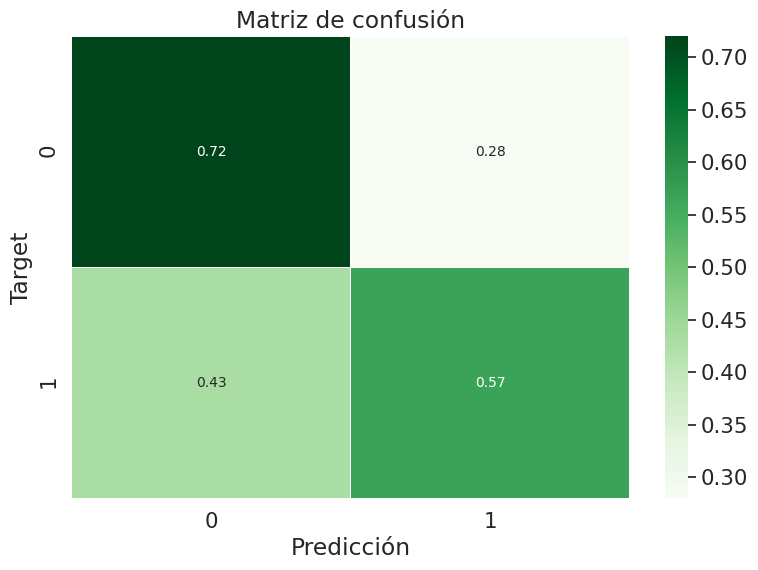

In [123]:
y = train_df['target']
columnas = ['id', 'keyword', 'location', 'text', 'target', 'text_clean']
X = train_df.drop(columnas, axis=1)



#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

#Norm
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

# Train
RFC = RandomForestClassifier(n_estimators = 200,  max_depth=8, max_features='auto',
                             criterion='entropy', random_state = 0)

RFC.fit(X_train_sc, y_train)

#Predict
y_pred = RFC.predict(X_test_sc)

#Métricas
mostrar_metricas(y_test, y_pred)


#Features importances
features = np.array(X.columns)
importances = RFC.feature_importances_

fig = go.Figure([go.Bar(x=X_train.columns, y=importances)])
fig.update_layout(title_text='Feature importances',
                      xaxis_title='Feature',
                      yaxis_title='Porcentaje',
                      template="ggplot2")
fig.show()


'''

#Tree
tree0 = RFC.estimators_[0]
fig, axes = plt.subplots(nrows = 1, ncols = 1,  figsize=(9,6), dpi=200)
plot_tree(tree0, feature_names = X_train.columns, filled = True)
plt.show()


#Buscando parámetros 'buenos'
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

#Grid Search train
GSCV = GridSearchCV(estimator=RFC, param_grid=param_grid, cv= 5)
GSCV.fit(X_train, y_train)

# Best paramns
print(GSCV.best_params_)

'''

print('')

# B. LightGBM / CatBoost

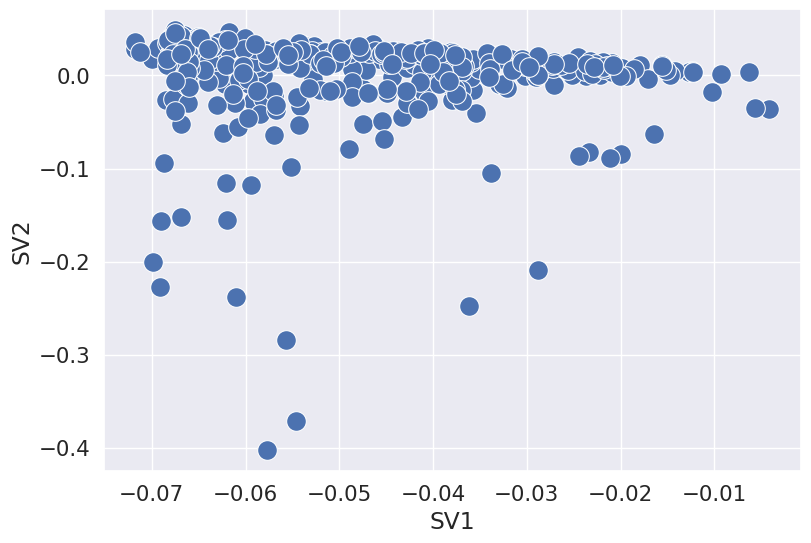

In [113]:
from sklearn.decomposition import PCA
from scipy.linalg import svd as scipy_svd

y = train_df['target']
columnas = ['id', 'keyword', 'location', 'text', 'target', 'text_clean']
X = train_df.drop(columnas, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.95, random_state = 0)


A = X_train.to_numpy()
U, S, V = scipy_svd(A, full_matrices = False)

labels= ['SV1', 'SV2']
svd_df = pd.DataFrame(U[:,0:2], columns=labels)
svd_df=svd_df.reset_index()
svd_df.rename(columns={'index':'Usuarios'}, inplace=True)
svd_df.Usuarios = svd_df.Usuarios + 1
svd_df.shape


sns.scatterplot(x="SV1", y="SV2",
                     palette="Set2",
                     s=200,
                     data=svd_df)


# 1.  LSTM - TEXT

Found 15846 unique tokens.
Shape of data tensor: (7613, 30)
Shape of label tensor: (7613, 2)
(5709, 30) (5709, 2)
(1904, 30) (1904, 2)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 100)           5000000   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 30, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 202       
Total params: 5,080,602
Trainable params: 5,080,602
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
81/81 [==============================] - 7s 90ms/step - loss: 0.5820 - accuracy: 0.6810 - va

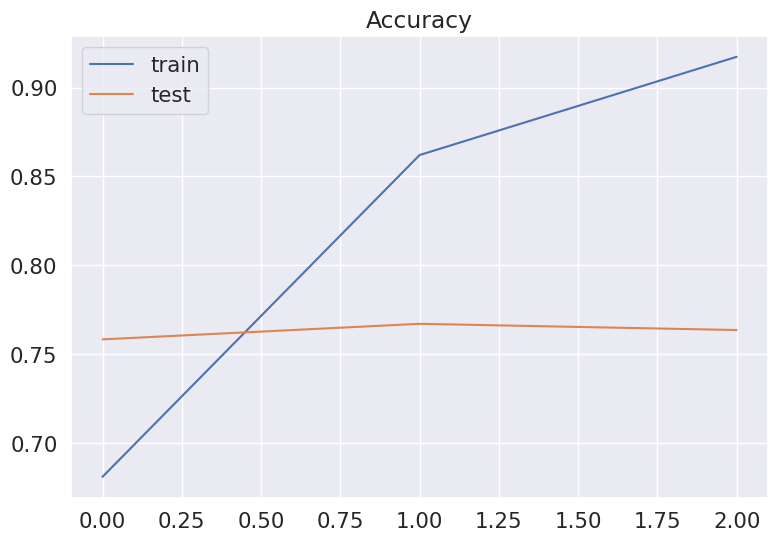

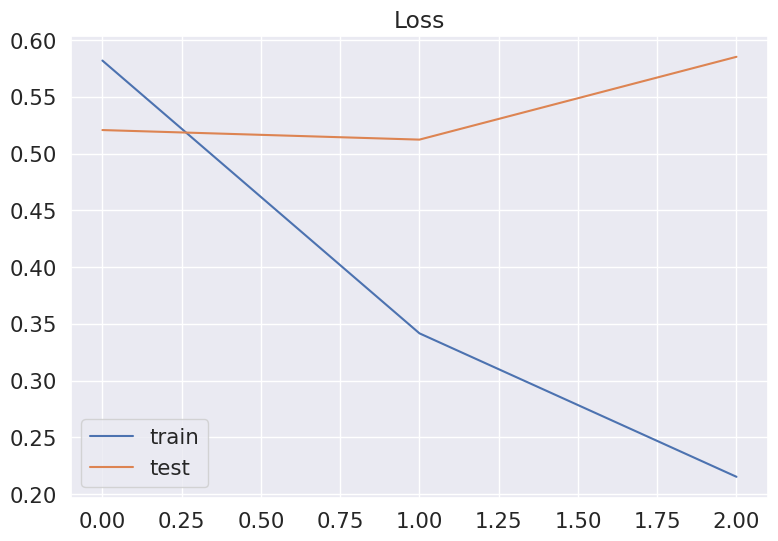

In [114]:

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
#InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

STOPWORDS = set(stopwords.words('english'))


# Cantidad de palabras a usar
MAX_NB_WORDS = 50000
# Número maximo de palabras en el campo text.
MAX_SEQUENCE_LENGTH = 30
# Fijo.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train_df['text_clean'].values)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(train_df['text_clean'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Y = pd.get_dummies(train_df['target']).values
print('Shape of label tensor:', Y.shape)



X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 0)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

epochs = 3
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

#Graficos
plt.figure()
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

plt.figure()
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();


# 2. XGBoost - TEXT

              precision    recall  f1-score   support

           0       0.77      0.86      0.81      1107
           1       0.77      0.64      0.70       797

    accuracy                           0.77      1904
   macro avg       0.77      0.75      0.75      1904
weighted avg       0.77      0.77      0.76      1904

[[951 156]
 [289 508]]


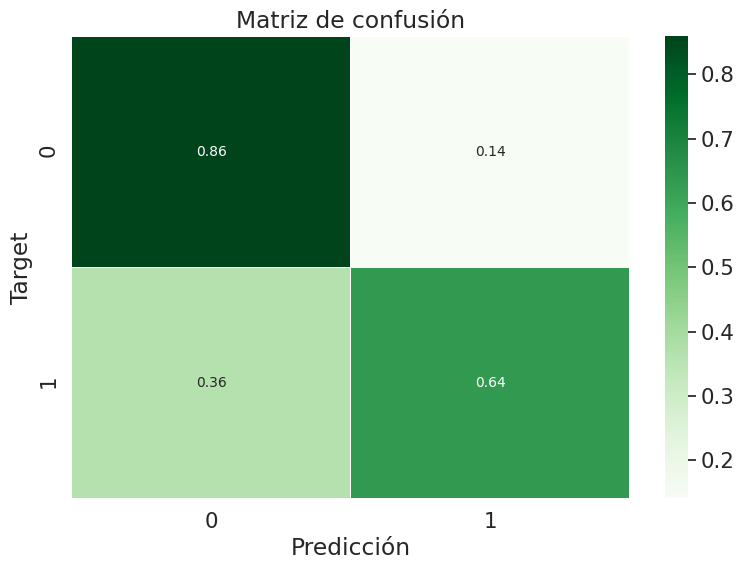

In [115]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBClassifier

X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# TF-IDF
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

#Entrenamiento
alg = XGBClassifier(learning_rate=0.1, n_estimators=300, max_depth=17,
                    min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                    objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

alg.fit(X_train, y_train, eval_metric='auc')

#Predicciones
y_pred = alg.predict(X_test)

#Métricas
mostrar_metricas(y_test, y_pred)

# 3.  Random Forest Classifier - TEXT

              precision    recall  f1-score   support

           0       0.69      0.99      0.81      1107
           1       0.97      0.38      0.55       797

    accuracy                           0.74      1904
   macro avg       0.83      0.69      0.68      1904
weighted avg       0.81      0.74      0.70      1904

[[1096   11]
 [ 492  305]]


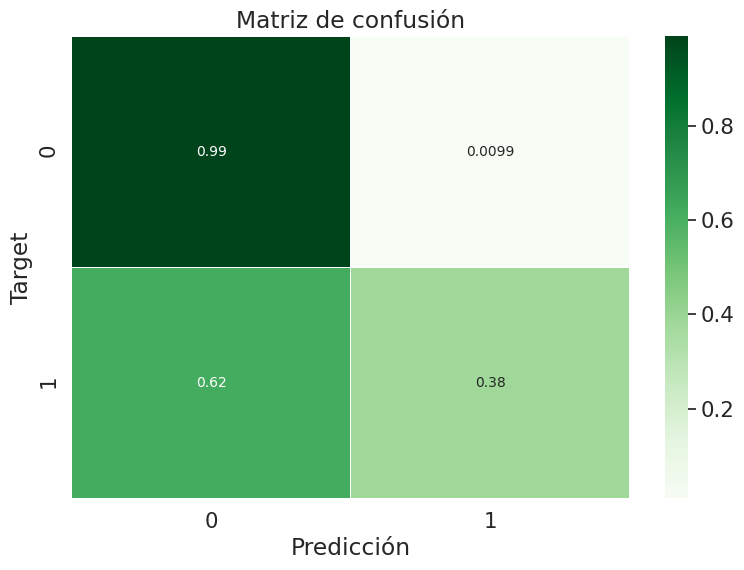

array([1.30023915e-04, 5.30843705e-07, 0.00000000e+00, ...,
       5.85920571e-08, 0.00000000e+00, 0.00000000e+00])

In [116]:
X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# transform  to a normalized tf-idf representation 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)


# Train
RFC = RandomForestClassifier(n_estimators = 500,  max_depth=25, max_features='auto',
                             criterion='entropy', n_jobs=-1)


RFC.fit(X_train, y_train)

#Predict
y_pred = RFC.predict(X_test)

#Métricas
mostrar_metricas(y_test, y_pred)

'''

#Buscando parámetros 'buenos'
param_grid = { 
    'n_estimators': [100, 600],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,5,7,9,11, 13],
    'criterion' :['gini', 'entropy']
}

#Grid Search train
GSCV = GridSearchCV(estimator=RFC, param_grid=param_grid, cv= 5)
GSCV.fit(X_train, y_train)

# Best paramns
print(GSCV.best_params_)
'''

RFC.feature_importances_

# 4. Regresión Logística - TEXT

              precision    recall  f1-score   support

           0       0.78      0.92      0.85      1107
           1       0.85      0.64      0.73       797

    accuracy                           0.80      1904
   macro avg       0.82      0.78      0.79      1904
weighted avg       0.81      0.80      0.80      1904

[[1017   90]
 [ 283  514]]


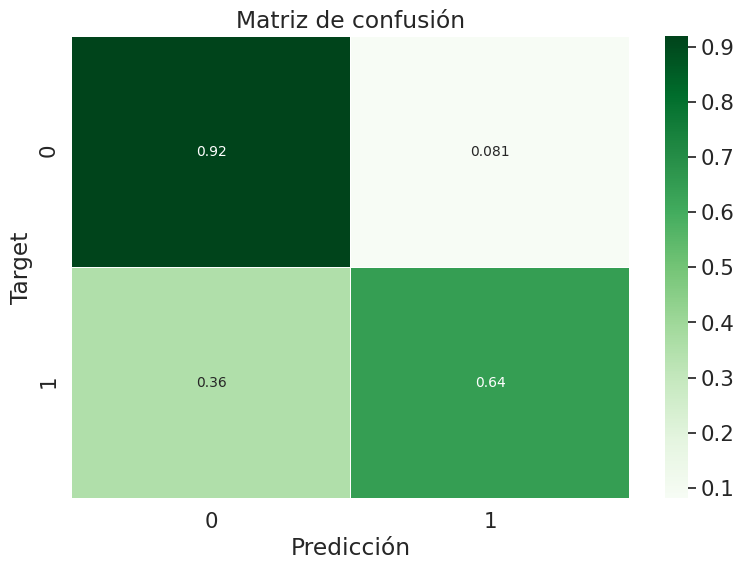

Weight?,Feature
+1.477,in
+1.010,california
+0.968,fires
+0.968,hiroshima
+0.805,of
+0.771,fire
+0.766,suicide
+0.713,after
+0.701,train
+0.682,killed


In [117]:
X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# TF-IDF
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

#Entrenamiento
LR = LogisticRegression(C=0.2, penalty= 'l2', multi_class='multinomial', n_jobs=4)
LR.fit(X_train, y_train)

#Métricas
y_pred = LR.predict(X_test)
mostrar_metricas(y_test, y_pred)

#Feature estimator
eli5.show_weights(estimator=LR,feature_names= list(count_vect.get_feature_names()),top=(20, 20))

# 5. KNN - TEXT

              precision    recall  f1-score   support

           0       0.77      0.92      0.84      1107
           1       0.85      0.62      0.72       797

    accuracy                           0.79      1904
   macro avg       0.81      0.77      0.78      1904
weighted avg       0.80      0.79      0.79      1904

[[1017   90]
 [ 303  494]]


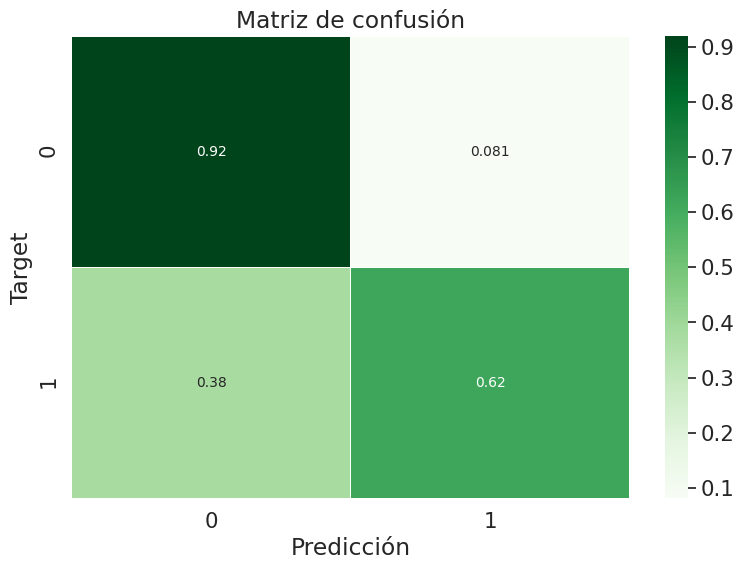

In [118]:
X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# TF-IDF 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

#Train
KNN = KNeighborsClassifier(n_neighbors = 80, metric='minkowski')
KNN.fit(X_train, y_train)

#Métricas
y_pred = KNN.predict(X_test)
mostrar_metricas(y_test, y_pred)

'''

#Buscando un K 'bueno'
k_range = range(1,100, 3)
scores = []


for k in k_range:
    KNN = KNeighborsClassifier(n_neighbors = k, metric='minkowski')
    KNN.fit(X_train, y_train)
    scores.append(KNN.score(X_test, y_test))
   # accuracy = metrics.accuracy_score(y_test, y_pred) #Accuracy

plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.show()

'''
print('')

# 6. Multinomial NB - TEXT

              precision    recall  f1-score   support

           0       0.78      0.92      0.84      1107
           1       0.85      0.63      0.73       797

    accuracy                           0.80      1904
   macro avg       0.81      0.78      0.78      1904
weighted avg       0.81      0.80      0.79      1904

[[1017   90]
 [ 292  505]]


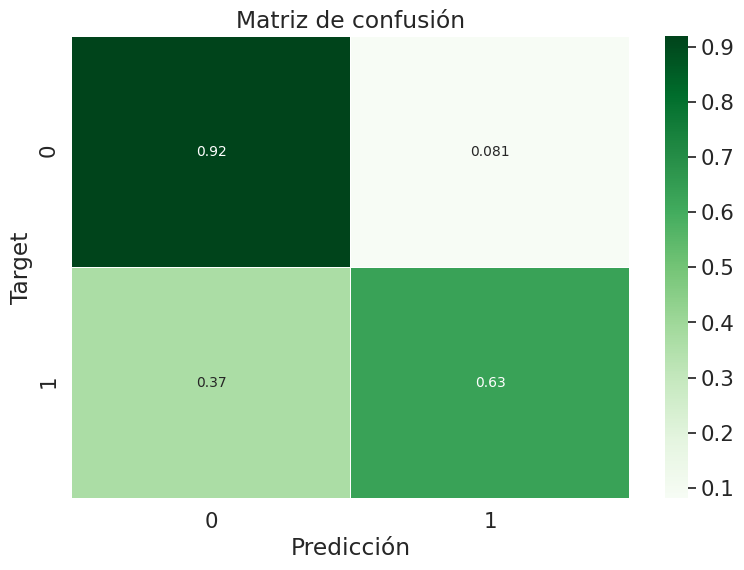

In [119]:
X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# TF-IDF 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)


# Train
MNB = MultinomialNB()
MNB.fit(X_train, y_train)

#Predict
y_pred = MNB.predict(X_test)

#Métricas
mostrar_metricas(y_test, y_pred)